In [23]:
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

In [24]:
df = pd.read_csv("..\OMLT_ML\data\polynomial3.csv")
df.head()

,theta,z,u
0,-20.0,-6.08,-3.92
1,-19.5,-5.58,-4.42
2,-19.1,-5.13,-4.87
3,-18.6,-4.71,-5.29
4,-18.1,-4.32,-5.68


In [25]:
X = df["theta"]
y = df["z"]

X = X.reset_index(drop = True)
y = y.reset_index(drop = True)

X = X.to_numpy().reshape(-1, 1)
y = y.to_numpy().reshape(-1, 1)

In [26]:
X.shape, y.shape

((180, 1), (180, 1))

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

train_data_linear = lgb.Dataset(X_train, label=y_train,
                        params={
                            'linear_tree': True
                        })

train_data_normal = lgb.Dataset(X_train, label=y_train)

In [28]:
params = {
    "objective": "regression",
    "metric": "rmse",
    "num_leaves": 100,
    "learning_rate": 0.1,
    "verbosity": -1
}

model_linear = lgb.train(params, train_data_linear)
model_normal = lgb.train(params, train_data_normal)

c:\Users\shumengl\.conda\envs\omlt\lib\site-packages\lightgbm\basic.py:154: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


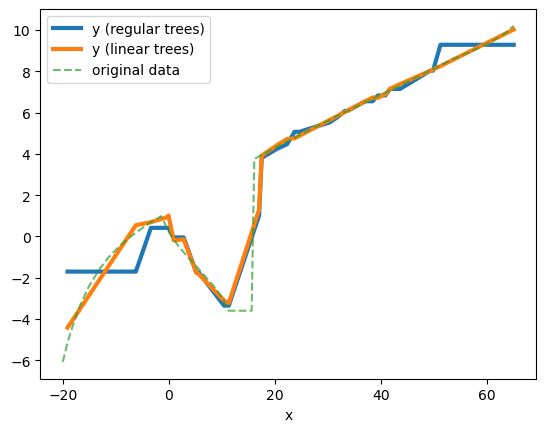

In [29]:
y_pred_linear = model_linear.predict(X_test, num_iteration=model_linear.best_iteration)
y_pred_normal = model_normal.predict(X_test, num_iteration=model_normal.best_iteration)
# plotting results
df = pd.DataFrame(X_test, columns=['x'])
df['y (regular trees)'] = y_pred_normal
df['y (linear trees)'] = y_pred_linear
df.sort_values('x').set_index('x').plot(lw=3)
plt.plot(X, y, label='original data', alpha=0.7, linestyle='--')
plt.legend()
plt.show()

In [30]:
print(f"Linear trees error: {round(mean_squared_error(y_test, y_pred_linear),3)}")
print(f"Normal trees error: {round(mean_squared_error(y_test, y_pred_normal),3)}")

Linear trees error: 0.186
Normal trees error: 1.069
